In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import linregress

In [3]:
fire_file="Resources/FW_Veg_Rem_Combined.csv"
fire_df=pd.read_csv(fire_file)
fire_df.head()

,Unnamed: 0,Unnamed: 0.1,fire_name,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,...,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
0,0,0,NaN,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2/11/2007,...,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923
1,1,1,NaN,3.0,B,Arson,35.038330,-87.610000,TN,12/11/2006,...,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
2,2,2,NaN,60.0,C,Arson,34.947800,-88.722500,MS,2/29/2004,...,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544
3,3,3,WNA 1,1.0,B,Debris Burning,39.641400,-119.308300,NV,6/6/2005,...,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447
4,4,4,NaN,2.0,B,Miscellaneous,30.700600,-90.591400,LA,9/22/1999,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633


In [4]:
##Data Cleaning
#Gathering records from California, greater than or equal to 10 acres, and with valid weather data
fire_df=fire_df.loc[(fire_df["state"]=="CA")&
                    (fire_df["fire_size"]>=10)&
                    (fire_df["weather_file"]!="File Not Found")&
                    (fire_df["Temp_pre_30"]!=0)&
                    (fire_df["Temp_pre_15"]!=0)&
                    (fire_df["Temp_pre_7"]!=0)&
                    (fire_df["Temp_cont"]!=0)]

#dropping unneeded columns
fire_df=fire_df.drop(columns=["Unnamed: 0",
                              "Unnamed: 0.1",
                              "state",
                              "cont_clean_date",
                              "disc_date_final",
                              "cont_date_final",
                              "disc_date_pre",
                              "disc_pre_year",
                              "disc_pre_month",
                              "wstation_usaf",
                              "dstation_m",
                              "wstation_wban",
                              "wstation_byear",
                              "wstation_eyear",
                              "fire_mag",
                              "weather_file"])
fire_df=fire_df.dropna()
fire_df=fire_df.drop_duplicates(subset="fire_name")

#renaming for aesthetics
fire_df=fire_df.rename(columns={"fire_name":"Fire Name",
                                "fire_size":"Fire Size",
                                "fire_size_class":"Fire Size Class",
                                "stat_cause_descr":"Fire Cause",
                                "latitude":"Latitude",
                                "longitude":"Longitude",
                                "disc_clean_date":"Date of Discovery",
                                "discovery_month":"Month of Discovery",
                                "putout_time":"Fire Duration",
                                "Temp_pre_30":"Temp 30 Days Prior",
                                "Temp_pre_15":"Temp 15 Days Prior",
                                "Temp_pre_7":"Temp 7 Days Prior",
                                "Temp_cont":"Temp on Containment",
                                "Wind_pre_30":"Wind 30 Days Prior",
                                "Wind_pre_15":"Wind 15 Days Prior",
                                "Wind_pre_7":"Wind 7 Days Prior",
                                "Wind_cont":"Wind on Containment",
                                "Hum_pre_30":"Humidity 30 Days Prior",
                                "Hum_pre_15":"Humidity 15 Days Prior",
                                "Hum_pre_7":"Humidity 7 Days Prior",
                                "Hum_cont":"Humidity on Containment",
                                "Prec_pre_30":"Precipitation 30 Days Prior",
                                "Prec_pre_15":"Precipitation 15 Days Prior",
                                "Prec_pre_7":"Precipitation 7 Days Prior",
                                "Prec_cont":"Precipitation on Containment",
                                "remoteness":"Remoteness"
})

In [5]:
#convert to farenheit
fire_df["Temp 30 Days Prior"]=(fire_df["Temp 30 Days Prior"] * 9/5) + 32
fire_df["Temp 15 Days Prior"]=(fire_df["Temp 15 Days Prior"] * 9/5) + 32
fire_df["Temp 7 Days Prior"]=(fire_df["Temp 7 Days Prior"] * 9/5) + 32
fire_df["Temp on Containment"]=(fire_df["Temp on Containment"] * 9/5) + 32

In [6]:
#making Fire Duration row float
fire_df['Fire Duration'] = fire_df['Fire Duration'].str.split(' ').str[0].astype("float")

In [14]:
#Creating Average dataframes based on Fire Class Size
class_size=fire_df.groupby("Fire Size Class")
wind_df=pd.DataFrame([class_size["Wind 30 Days Prior"].mean(),
                      class_size["Wind 15 Days Prior"].mean(),
                      class_size["Wind 7 Days Prior"].mean(),
                      class_size["Wind on Containment"].mean()]).T
wind_df["Fire Size Range"]=["11-100 Acres","100-250 Acres","251-1000 Acres","1001-5000 Acres",">5001 Acres"]

temp_df=pd.DataFrame([class_size["Temp 30 Days Prior"].mean(),
                      class_size["Temp 15 Days Prior"].mean(),
                      class_size["Temp 7 Days Prior"].mean(),
                      class_size["Temp on Containment"].mean()]).T
temp_df["Fire Size Range"]=["11-100 Acres","100-250 Acres","251-1000 Acres","1001-5000 Acres",">5001 Acres"]

hum_df=pd.DataFrame([class_size["Humidity 30 Days Prior"].mean(),
                      class_size["Humidity 15 Days Prior"].mean(),
                      class_size["Humidity 7 Days Prior"].mean(),
                      class_size["Humidity on Containment"].mean()]).T
hum_df["Fire Size Range"]=["11-100 Acres","100-250 Acres","251-1000 Acres","1001-5000 Acres",">5001 Acres"]

prec_df=pd.DataFrame([class_size["Precipitation 30 Days Prior"].mean(),
                      class_size["Precipitation 15 Days Prior"].mean(),
                      class_size["Precipitation 7 Days Prior"].mean(),
                      class_size["Precipitation on Containment"].mean()]).T
prec_df["Fire Size Range"]=["11-100 Acres","100-250 Acres","251-1000 Acres","1001-5000 Acres",">5001 Acres"]



In [15]:
wind_df

,Wind 30 Days Prior,Wind 15 Days Prior,Wind 7 Days Prior,Wind on Containment,Fire Size Range
Fire Size Class,,,,,
C,2.795112,2.793418,2.714922,2.704893,11-100 Acres
D,3.175000,3.060215,3.085903,3.183021,100-250 Acres
E,2.949511,2.955312,2.923454,2.969513,251-1000 Acres
F,2.907676,2.853600,2.794378,2.790411,1001-5000 Acres
G,2.939920,2.898586,2.821532,2.939257,>5001 Acres


Text(0.5, 0, 'Wind (m/s)')

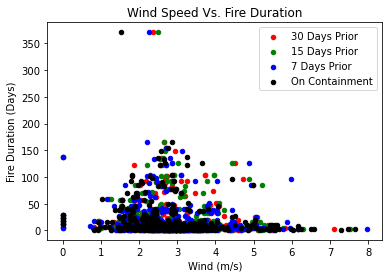

In [7]:
ax1 = fire_df.plot(kind='scatter', y='Fire Duration', x='Wind 30 Days Prior', color='r',label='30 Days Prior',title="Wind Speed Vs. Fire Duration")    
ax2 = fire_df.plot(kind='scatter', y='Fire Duration', x='Wind 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Duration', x='Wind 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Duration', x='Wind on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Duration (Days)")
ax1.set_xlabel("Wind (m/s)")

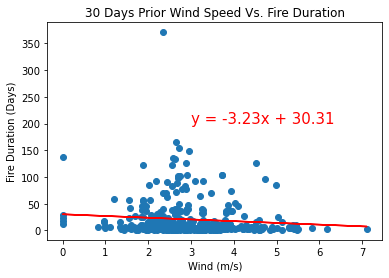

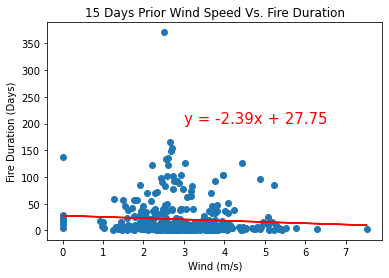

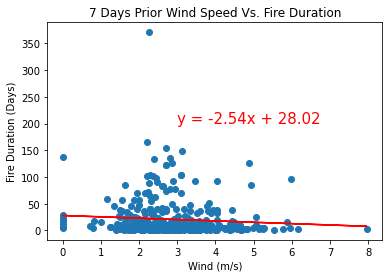

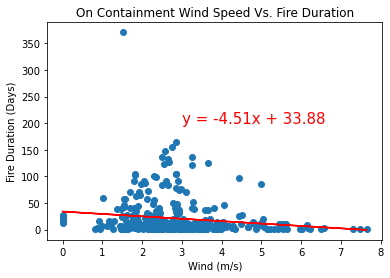

In [66]:
# Wind 30 Days Prior
x_30 = fire_df['Wind 30 Days Prior'].astype('float')
y_values = fire_df['Fire Duration'].astype('float')

# Plot scatter plot
plt.scatter(x_30,y_values)

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_30,y_values)
regress_values = x_30 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot regression line
plt.plot(x_30,regress_values,"r-")
plt.annotate(line_eq,(3,200),fontsize=15,color="r")
plt.title("30 Days Prior Wind Speed Vs. Fire Duration")

# Label plot
plt.ylabel("Fire Duration (Days)")
plt.xlabel("Wind (m/s)")
plt.show()

# Wind 15 Days Prior
x_15 = fire_df['Wind 15 Days Prior'].astype('float')

plt.scatter(x_15,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_15,y_values)
regress_values = x_15 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_15,regress_values,"r-")
plt.annotate(line_eq,(3,200),fontsize=15,color="r")
plt.title("15 Days Prior Wind Speed Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Wind (m/s)")
plt.show()

# Wind 7 Days Prior
x_7 = fire_df['Wind 7 Days Prior'].astype('float')

plt.scatter(x_7,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_7,y_values)
regress_values = x_7 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_7,regress_values,"r-")
plt.annotate(line_eq,(3,200),fontsize=15,color="r")
plt.title("7 Days Prior Wind Speed Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Wind (m/s)")
plt.show()

# Wind on Containment
x_c = fire_df['Wind on Containment'].astype('float')

plt.scatter(x_c,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_c,y_values)
regress_values = x_c * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_c,regress_values,"r-")
plt.annotate(line_eq,(3,200),fontsize=15,color="r")
plt.title("On Containment Wind Speed Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Wind (m/s)")
plt.show()

Text(0.5, 0, 'Wind (m/s)')

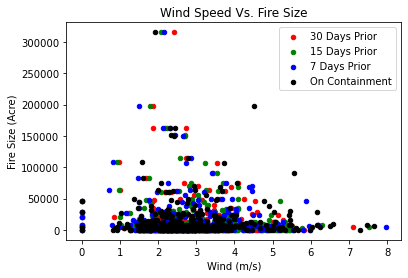

In [8]:
ax1 = fire_df.plot(kind='scatter', y='Fire Size', x='Wind 30 Days Prior', color='r',label='30 Days Prior',title="Wind Speed Vs. Fire Size")    
ax2 = fire_df.plot(kind='scatter', y='Fire Size', x='Wind 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Size', x='Wind 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Size', x='Wind on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Size (Acre)")
ax1.set_xlabel("Wind (m/s)")

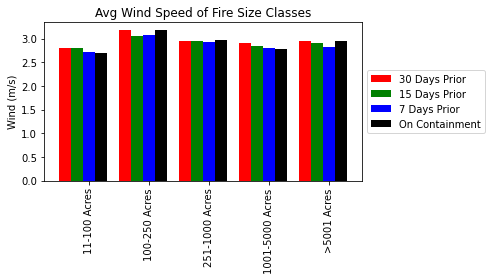

In [9]:
x = np.arange(len(wind_df.index))
width = .2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width,wind_df["Wind 30 Days Prior"],width, label="30 Days Prior",color="r")
rects2 = ax.bar(x - width,wind_df["Wind 15 Days Prior"],width, label="15 Days Prior", color='g')
rects3 = ax.bar(x,wind_df["Wind 7 Days Prior"],width, label="7 Days Prior", color='b')
rects4 = ax.bar(x+width,wind_df["Wind on Containment"],width, label="On Containment", color='0')
 
ax.set_ylabel('Wind (m/s)')
ax.set_title('Avg Wind Speed of Fire Size Classes')
ax.set_xticks(x)
ax.set_xticklabels(wind_df["Fire Size Range"],rotation="90")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



fig.tight_layout()

Text(0.5, 0, 'Temp (F)')

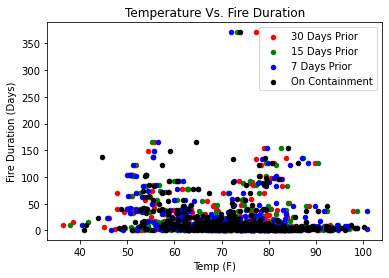

In [10]:
ax1 = fire_df.plot(kind='scatter', y='Fire Duration', x='Temp 30 Days Prior', color='r',label='30 Days Prior',title="Temperature Vs. Fire Duration")    
ax2 = fire_df.plot(kind='scatter', y='Fire Duration', x='Temp 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Duration', x='Temp 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Duration', x='Temp on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Duration (Days)")
ax1.set_xlabel("Temp (F)")

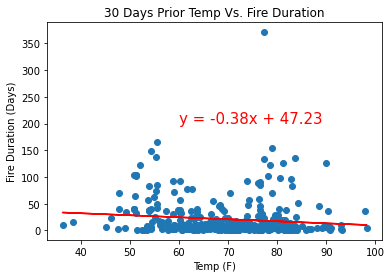

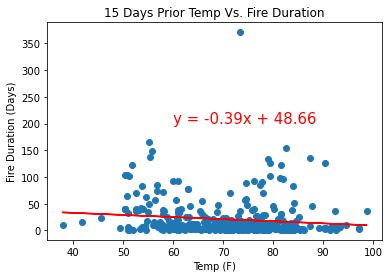

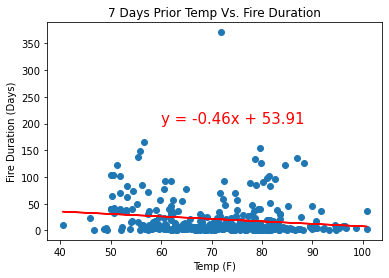

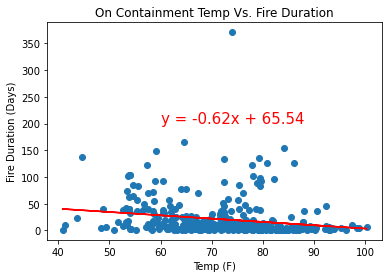

In [68]:
# Temp 30 Days Prior
x_30 = fire_df['Temp 30 Days Prior'].astype('float')
y_values = fire_df['Fire Duration'].astype('float')

# Plot scatter plot
plt.scatter(x_30,y_values)

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_30,y_values)
regress_values = x_30 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot regression line
plt.plot(x_30,regress_values,"r-")
plt.annotate(line_eq,(60,200),fontsize=15,color="r")
plt.title("30 Days Prior Temp Vs. Fire Duration")

# Label plot
plt.ylabel("Fire Duration (Days)")
plt.xlabel("Temp (F)")
plt.show()

# Temp 15 Days Prior
x_15 = fire_df['Temp 15 Days Prior'].astype('float')

plt.scatter(x_15,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_15,y_values)
regress_values = x_15 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_15,regress_values,"r-")
plt.annotate(line_eq,(60,200),fontsize=15,color="r")
plt.title("15 Days Prior Temp Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Temp (F)")
plt.show()

# Temp 7 Days Prior
x_7 = fire_df['Temp 7 Days Prior'].astype('float')

plt.scatter(x_7,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_7,y_values)
regress_values = x_7 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_7,regress_values,"r-")
plt.annotate(line_eq,(60,200),fontsize=15,color="r")
plt.title("7 Days Prior Temp Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Temp (F)")
plt.show()

# Temp on Containment
x_c = fire_df['Temp on Containment'].astype('float')

plt.scatter(x_c,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_c,y_values)
regress_values = x_c * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_c,regress_values,"r-")
plt.annotate(line_eq,(60,200),fontsize=15,color="r")
plt.title("On Containment Temp Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Temp (F)")
plt.show()

Text(0.5, 0, 'Temp (F)')

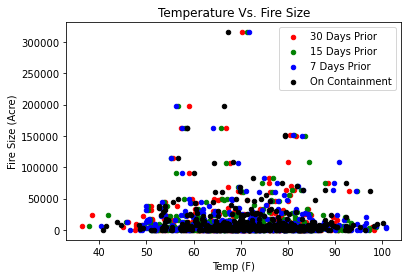

In [11]:
ax1 = fire_df.plot(kind='scatter', y='Fire Size', x='Temp 30 Days Prior', color='r',label='30 Days Prior',title="Temperature Vs. Fire Size")    
ax2 = fire_df.plot(kind='scatter', y='Fire Size', x='Temp 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Size', x='Temp 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Size', x='Temp on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Size (Acre)")
ax1.set_xlabel("Temp (F)")

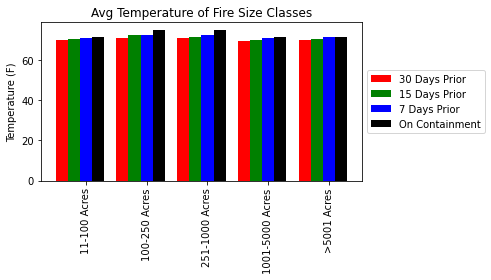

In [12]:
x = np.arange(len(temp_df.index))
width = .2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width,temp_df["Temp 30 Days Prior"],width, label="30 Days Prior",color="r")
rects2 = ax.bar(x - width,temp_df["Temp 15 Days Prior"],width, label="15 Days Prior", color='g')
rects3 = ax.bar(x,temp_df["Temp 7 Days Prior"],width, label="7 Days Prior", color='b')
rects4 = ax.bar(x+width,temp_df["Temp on Containment"],width, label="On Containment", color='0')
 
ax.set_ylabel('Temperature (F)')
ax.set_title('Avg Temperature of Fire Size Classes')
ax.set_xticks(x)
ax.set_xticklabels(temp_df["Fire Size Range"],rotation="90")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



fig.tight_layout()

Text(0.5, 0, 'Humidity (%)')

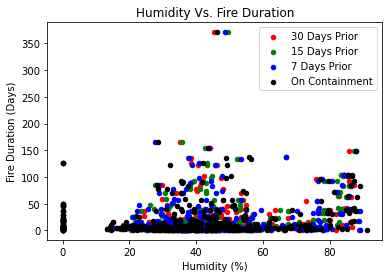

In [13]:
ax1 = fire_df.plot(kind='scatter', y='Fire Duration', x='Humidity 30 Days Prior', color='r',label='30 Days Prior',title="Humidity Vs. Fire Duration")    
ax2 = fire_df.plot(kind='scatter', y='Fire Duration', x='Humidity 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Duration', x='Humidity 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Duration', x='Humidity on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Duration (Days)")
ax1.set_xlabel("Humidity (%)")

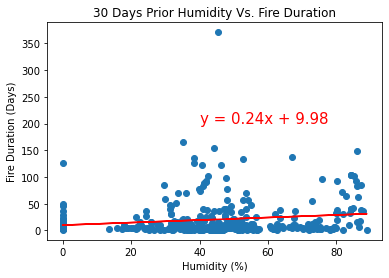

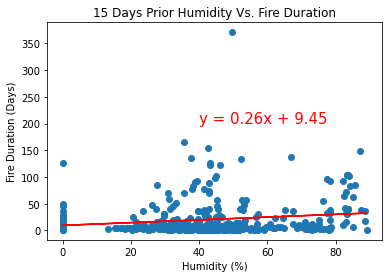

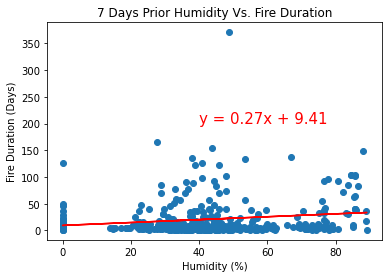

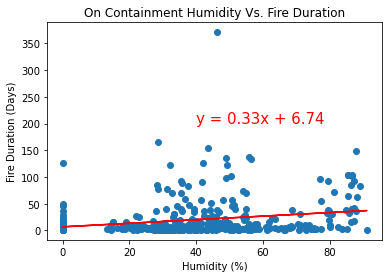

In [70]:
# Humidity 30 Days Prior
x_30 = fire_df['Humidity 30 Days Prior'].astype('float')
y_values = fire_df['Fire Duration'].astype('float')

# Plot scatter plot
plt.scatter(x_30,y_values)

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_30,y_values)
regress_values = x_30 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot regression line
plt.plot(x_30,regress_values,"r-")
plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("30 Days Prior Humidity Vs. Fire Duration")

# Label plot
plt.ylabel("Fire Duration (Days)")
plt.xlabel("Humidity (%)")
plt.show()

# Humidity 15 Days Prior
x_15 = fire_df['Humidity 15 Days Prior'].astype('float')

plt.scatter(x_15,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_15,y_values)
regress_values = x_15 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_15,regress_values,"r-")
plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("15 Days Prior Humidity Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Humidity (%)")
plt.show()

# Humidity 7 Days Prior
x_7 = fire_df['Humidity 7 Days Prior'].astype('float')

plt.scatter(x_7,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_7,y_values)
regress_values = x_7 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_7,regress_values,"r-")
plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("7 Days Prior Humidity Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Humidity (%)")
plt.show()

# Humidity on Containment
x_c = fire_df['Humidity on Containment'].astype('float')

plt.scatter(x_c,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_c,y_values)
regress_values = x_c * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_c,regress_values,"r-")
plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("On Containment Humidity Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Humidity (%)")
plt.show()

Text(0.5, 0, 'Humidity (%)')

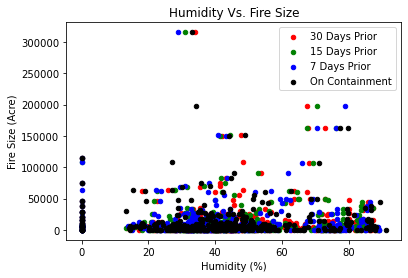

In [14]:
ax1 = fire_df.plot(kind='scatter', y='Fire Size', x='Humidity 30 Days Prior', color='r',label='30 Days Prior',title="Humidity Vs. Fire Size")    
ax2 = fire_df.plot(kind='scatter', y='Fire Size', x='Humidity 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Size', x='Humidity 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Size', x='Humidity on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Size (Acre)")
ax1.set_xlabel("Humidity (%)")

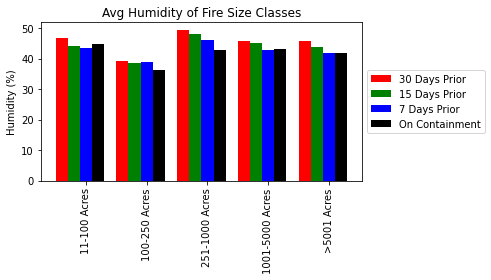

In [15]:
x = np.arange(len(hum_df.index))
width = .2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width,hum_df["Humidity 30 Days Prior"],width, label="30 Days Prior",color="r")
rects2 = ax.bar(x - width,hum_df["Humidity 15 Days Prior"],width, label="15 Days Prior", color='g')
rects3 = ax.bar(x,hum_df["Humidity 7 Days Prior"],width, label="7 Days Prior", color='b')
rects4 = ax.bar(x+width,hum_df["Humidity on Containment"],width, label="On Containment", color='0')
 
ax.set_ylabel('Humidity (%)')
ax.set_title('Avg Humidity of Fire Size Classes')
ax.set_xticks(x)
ax.set_xticklabels(wind_df["Fire Size Range"],rotation="90")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



fig.tight_layout()

Text(0.5, 0, 'Precipitation (mm)')

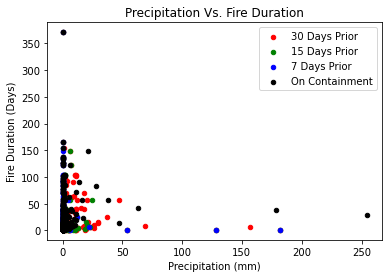

In [16]:
ax1 = fire_df.plot(kind='scatter', y='Fire Duration', x='Precipitation 30 Days Prior', color='r',label='30 Days Prior',title="Precipitation Vs. Fire Duration")    
ax2 = fire_df.plot(kind='scatter', y='Fire Duration', x='Precipitation 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Duration', x='Precipitation 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Duration', x='Precipitation on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Duration (Days)")
ax1.set_xlabel("Precipitation (mm)")

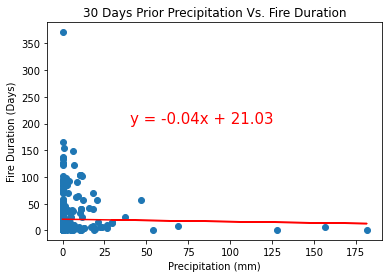

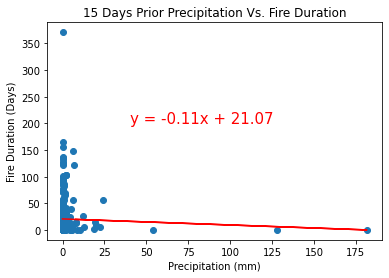

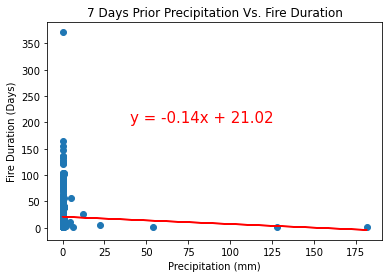

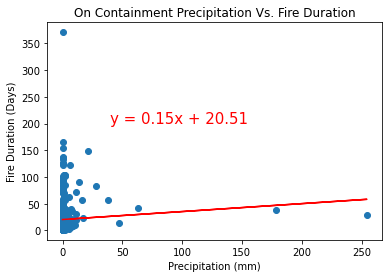

In [72]:
# Precipitation 30 Days Prior
x_30 = fire_df['Precipitation 30 Days Prior'].astype('float')
y_values = fire_df['Fire Duration'].astype('float')

# Plot scatter plot
plt.scatter(x_30,y_values)

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_30,y_values)
regress_values = x_30 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot regression line
plt.plot(x_30,regress_values,"r-")
plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("30 Days Prior Precipitation Vs. Fire Duration")

# Label plot
plt.ylabel("Fire Duration (Days)")
plt.xlabel("Precipitation (mm)")
plt.show()

# Precipitation 15 Days Prior
x_15 = fire_df['Precipitation 15 Days Prior'].astype('float')

plt.scatter(x_15,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_15,y_values)
regress_values = x_15 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_15,regress_values,"r-")
plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("15 Days Prior Precipitation Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Precipitation (mm)")
plt.show()

# Precipitation 7 Days Prior
x_7 = fire_df['Precipitation 7 Days Prior'].astype('float')

plt.scatter(x_7,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_7,y_values)
regress_values = x_7 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_7,regress_values,"r-")
plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("7 Days Prior Precipitation Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Precipitation (mm)")
plt.show()

# Precipitation on Containment
x_c = fire_df['Precipitation on Containment'].astype('float')

plt.scatter(x_c,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_c,y_values)
regress_values = x_c * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_c,regress_values,"r-")
plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("On Containment Precipitation Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Precipitation (mm)")
plt.show()

Text(0.5, 0, 'Precipitation (mm)')

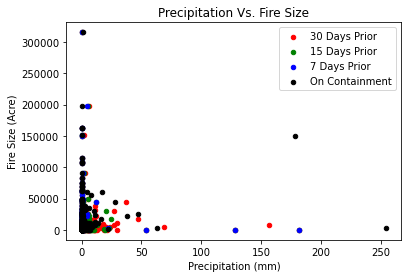

In [17]:
ax1 = fire_df.plot(kind='scatter', y='Fire Size', x='Precipitation 30 Days Prior', color='r',label='30 Days Prior',title="Precipitation Vs. Fire Size")    
ax2 = fire_df.plot(kind='scatter', y='Fire Size', x='Precipitation 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Size', x='Precipitation 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Size', x='Precipitation on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Size (Acre)")
ax1.set_xlabel("Precipitation (mm)")

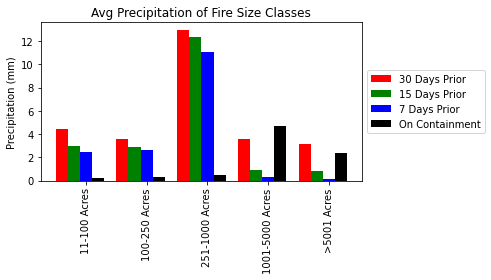

In [18]:
x = np.arange(len(prec_df.index))
width = .2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width,prec_df["Precipitation 30 Days Prior"],width, label="30 Days Prior",color="r")
rects2 = ax.bar(x - width,prec_df["Precipitation 15 Days Prior"],width, label="15 Days Prior", color='g')
rects3 = ax.bar(x,prec_df["Precipitation 7 Days Prior"],width, label="7 Days Prior", color='b')
rects4 = ax.bar(x+width,prec_df["Precipitation on Containment"],width, label="On Containment", color='0')
 
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Avg Precipitation of Fire Size Classes')
ax.set_xticks(x)
ax.set_xticklabels(wind_df["Fire Size Range"],rotation="90")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



fig.tight_layout()